<a href="https://colab.research.google.com/github/CaptaiN785/DL-Notebooks/blob/main/Face-mask-detection-biased/face_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* <code> Dataset link : https://www.kaggle.com/datasets/andrewmvd/face-mask-detection </code>

### Worst model is designed
* **mask_weared_incorrect has accuracy => 0.0**
* **without_mask has accuracy => 0.0**
* **with_mask has accuracy => 0.9938176197836167**<br><br>

- Model is predicting only with_mask because there are much more data of with_mask and very less of others.

In [ ]:
!unzip "/content/drive/MyDrive/face_mask.zip"

In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm

In [3]:
image_path = "/content/images"

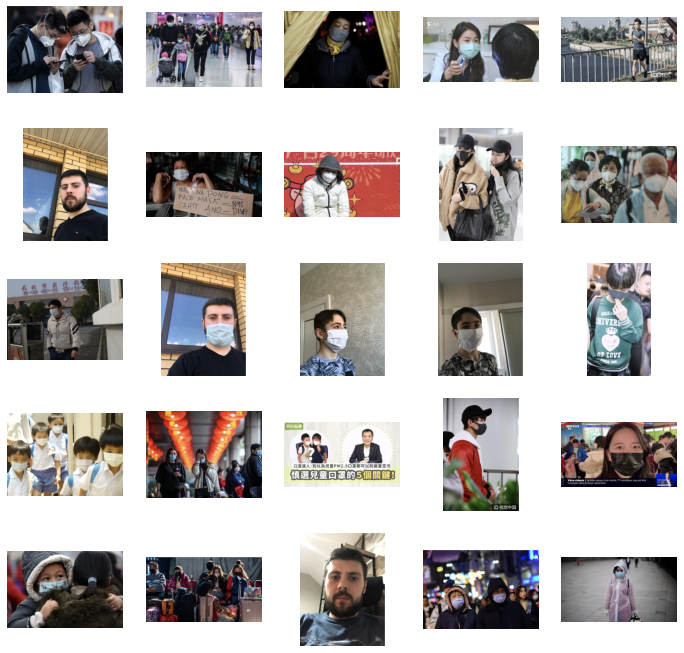

In [4]:
## Let's plot some of images from the dataset to get some idea

plt.figure(figsize=(12, 12))
for i, img_name in enumerate(os.listdir(image_path)[:25]):
    plt.subplot(5, 5, i+1)
    img = plt.imread(os.path.join(image_path, img_name))
    plt.imshow(img)
    plt.axis("off")
plt.show()

In [5]:
## Study the annotation file
import xml.etree.ElementTree as ET

In [6]:
## Reading the annotation file for each images
## Finding the dimension of each faces in a image

def annot(annotation_path): 

    tree = ET.parse(annotation_path)
    root = tree.getroot()

    data = []

    filename = None
    width = None
    height = None
    depth = None

    for element in tree.iter():
        if element.tag == 'filename':
            filename = element.text[:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    width = int(dim.text)
                if dim.tag == 'height':
                    height = int(dim.text)
                if dim.tag == 'depth':
                    depth = int(dim.text)
        if element.tag == 'object':
            xmin = 0
            ymin = 0
            xmax = 0
            ymax = 0
            for features in element.iter():
                if features.tag == 'name':
                    label = features.text
                if features.tag == 'bndbox':
                    for face in list(features):
                        if face.tag == 'xmin':
                            xmin = int(face.text)
                        if face.tag == 'ymin':
                            ymin = int(face.text)
                        if face.tag == 'xmax':
                            xmax = int(face.text)
                        if face.tag == 'ymax':
                            ymax = int(face.text)
            ## Appending it like image_name, width, height, depth, xmin, ymin, xmax, ymax and label of face
            data.append([filename, width, height, depth, xmin, ymin, xmax, ymax, label])
    return data

In [7]:
## Creating a dataframe using these annotation file
annot_path = "/content/annotations"

data = []

for file_name in os.listdir(annot_path):
    result = annot(os.path.join(annot_path, file_name))
    for res in result:
        data.append(res)
data = np.array(data)

In [8]:
data.shape

(4072, 9)

In [9]:
## Now making a dataframe of it
import pandas as pd
df = pd.DataFrame(data = data, columns = ["name", "width", "height", "depth", "xmin", "ymin", "xmax", "ymax", "label"])
df.head()

,name,width,height,depth,xmin,ymin,xmax,ymax,label
0,maksssksksss273,301,400,3,81,143,187,277,with_mask
1,maksssksksss725,301,400,3,45,215,138,336,with_mask
2,maksssksksss795,400,300,3,8,1,31,23,without_mask
3,maksssksksss795,400,300,3,9,91,31,119,with_mask
4,maksssksksss795,400,300,3,86,68,110,92,with_mask


In [10]:
## Cheking the bias of data
df['label'].value_counts()

with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: label, dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    4072 non-null   object
 1   width   4072 non-null   object
 2   height  4072 non-null   object
 3   depth   4072 non-null   object
 4   xmin    4072 non-null   object
 5   ymin    4072 non-null   object
 6   xmax    4072 non-null   object
 7   ymax    4072 non-null   object
 8   label   4072 non-null   object
dtypes: object(9)
memory usage: 286.4+ KB


In [12]:
df[df.columns[1:-1]] = df[df.columns[1:-1]].astype(int)

In [13]:
## Checking the no of faces that can be obtained from the single image
df.groupby("name")['label'].value_counts().sort_values()

name             label       
maksssksksss479  with_mask        1
maksssksksss514  without_mask     1
maksssksksss515  with_mask        1
maksssksksss520  with_mask        1
maksssksksss521  without_mask     1
                                 ..
maksssksksss539  with_mask       40
maksssksksss260  with_mask       53
maksssksksss240  without_mask    57
maksssksksss518  with_mask       71
maksssksksss603  with_mask       98
Name: label, Length: 1151, dtype: int64

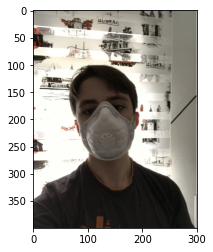

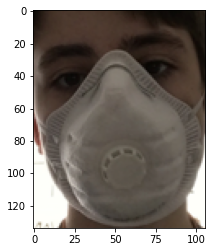

In [14]:
img = plt.imread("images/"+df["name"].iloc[0]+".png")
plt.imshow(img)
plt.show()

new_img = img[df['ymin'].iloc[0]:df['ymax'].iloc[0], df['xmin'].iloc[0]:df['xmax'].iloc[0]]
plt.imshow(new_img)

In [15]:
df['label'].unique()

array(['with_mask', 'without_mask', 'mask_weared_incorrect'], dtype=object)

In [16]:
## Now take 80% of data of each group for training and rest for testing purpose
## From training taking 85% of data for validation purpose.

from sklearn.model_selection import train_test_split

## Splitting the data for having the mask

mask_df = df[df['label'] == 'with_mask']

X_with_mask = mask_df.drop('label' , axis=1)
y_with_mask = mask_df['label']

X_train_wm, X_test_wm, y_train_wm, y_test_wm = train_test_split(X_with_mask, y_with_mask, test_size = 0.2, random_state = 42)

X_train_wm, X_val_wm, y_train_wm, y_val_wm = train_test_split(X_train_wm, y_train_wm, test_size = 0.15, random_state = 0)

In [17]:
## splitting the data for not having wearing the mask

without_mask_df = df[df['label'] == 'without_mask']

X_without_mask = without_mask_df.drop("label", axis = 1)
y_without_mask = without_mask_df['label']

X_train_wom, X_test_wom, y_train_wom, y_test_wom = train_test_split(X_without_mask, y_without_mask, test_size = 0.2, random_state=42)

X_train_wom, X_val_wom, y_train_wom, y_val_wom = train_test_split(X_train_wom, y_train_wom, test_size = 0.15, random_state = 0)

In [18]:
## Now splitting the data  having mask_weared_incorrect

mwi_df = df[df['label'] == "mask_weared_incorrect"]

X_mwi = mwi_df.drop('label', axis = 1)
y_mwi = mwi_df['label']

X_train_mwi, X_test_mwi, y_train_mwi, y_test_mwi = train_test_split(X_mwi, y_mwi, test_size = 0.2, random_state=42)

X_train_mwi, X_val_mwi, y_train_mwi, y_val_mwi = train_test_split(X_train_mwi, y_train_mwi, test_size= 0.15, random_state = 0)

In [19]:
## Now combining all training, validating and testing data together

## Combining the training data together
X_train = pd.concat([X_train_wm, X_train_wom, X_train_mwi])
y_train = pd.concat([y_train_wm, y_train_wom, y_train_mwi])

X_val = pd.concat([X_val_wm, X_val_wom, X_val_mwi])
y_val = pd.concat([y_val_wm, y_val_wom, y_val_mwi])

X_test = pd.concat([X_test_wm, X_test_wom, X_test_mwi])
y_test = pd.concat([y_test_wm, y_test_wom, y_test_mwi])

In [20]:
train = pd.concat([X_train, y_train], axis = 1)
val = pd.concat([X_val, y_val], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

In [21]:
## Now performing the face cropping from images

import cv2

def crop_and_save(df, img_path, save_path):

    for i, ind in tqdm(enumerate(df.index)): ## iteraing through each row
        img = cv2.imread(img_path + "/"+ df['name'][ind] + '.png')

        new_img = img[df['ymin'][ind]:df['ymax'][ind], df['xmin'][ind]:df['xmax'][ind]]

        image_path_and_name = os.path.join(save_path, os.path.join(df['label'][ind], f"{i+1}.png"))
        cv2.imwrite(image_path_and_name, new_img)
    print("\nDone")

In [22]:
## Providing the path for images to be saved
train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/test"


In [23]:
## Creating the folders

def create_folders(path):
    for label in df['label'].unique():
        os.makedirs(os.path.join(path, label))
        print(path + " => " + label)

In [24]:
create_folders(train_dir)
create_folders(val_dir)
create_folders(test_dir)

/content/train => with_mask
/content/train => without_mask
/content/train => mask_weared_incorrect
/content/val => with_mask
/content/val => without_mask
/content/val => mask_weared_incorrect
/content/test => with_mask
/content/test => without_mask
/content/test => mask_weared_incorrect


In [25]:
crop_and_save(train, image_path, train_dir)
crop_and_save(val, image_path, val_dir)
crop_and_save(test, image_path, test_dir)

2767it [00:46, 59.94it/s]



Done


489it [00:07, 62.14it/s]



Done


816it [00:13, 61.90it/s]


Done


In [26]:
## Now printing some of images from the dataset

def print_images(path):
    i = 1
    plt.figure(figsize = (12, 12))
    for p in os.listdir(path):
        file_path = os.path.join(path, p)
        for img in os.listdir(file_path)[:5]:
            img_path = os.path.join(file_path, img)
            image = plt.imread(img_path)
            plt.subplot(3, 5,i)
            plt.imshow(image)
            plt.axis("off")
            plt.title(p+f"({image.shape})")
            i += 1

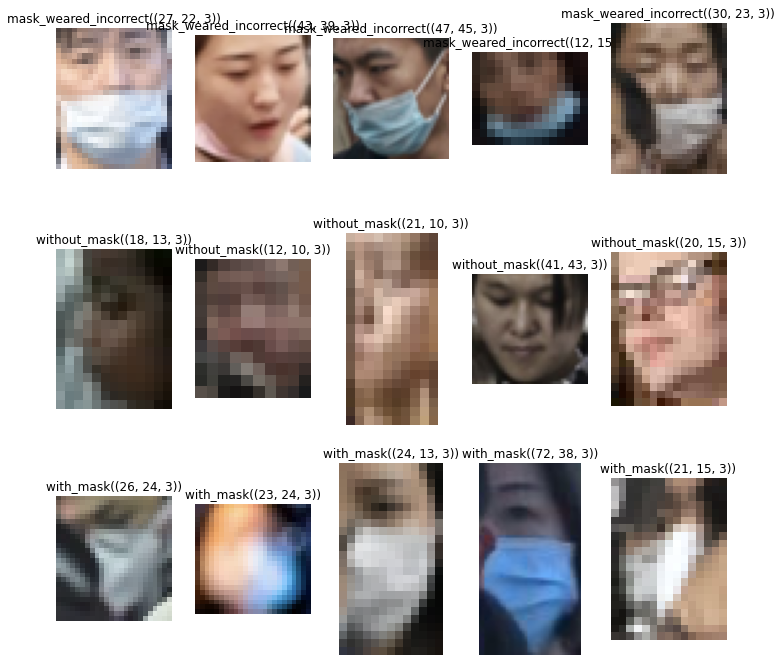

In [27]:
print_images(train_dir)

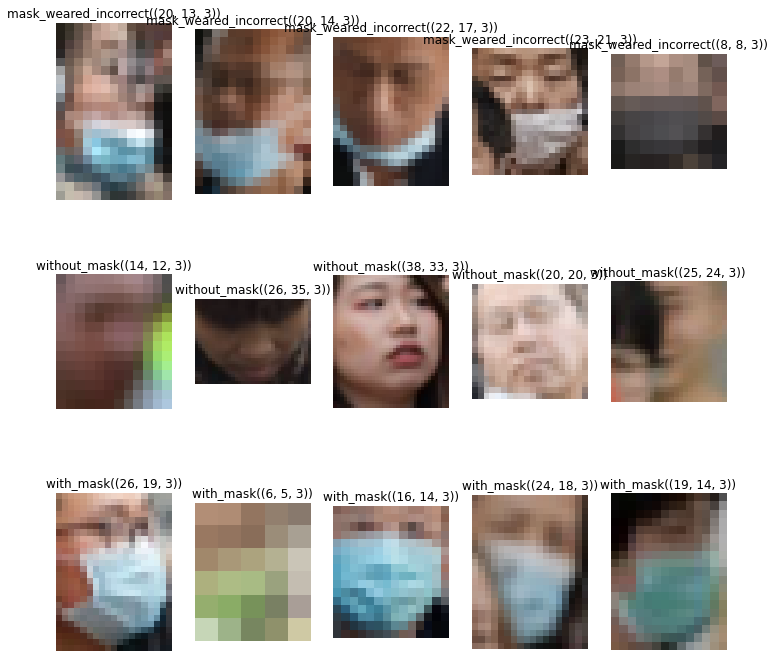

In [28]:
print_images(val_dir)

In [29]:
## Now data is completely build
## Model building

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [30]:
model = models.Sequential([
    layers.Input(shape=(28, 28, 3)),
    layers.Conv2D(32, (5, 5),strides = (2, 2) ,padding = "same", activation = 'relu'),
    layers.MaxPool2D((3, 3)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), padding = "same", activation = "relu"),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3, 3), padding = "same", activation = "relu"),
    layers.Conv2D(128, (3, 3), padding = "same", activation = "relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(3, activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 4, 4, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 64)          0

In [31]:
model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = ["acc"])

In [32]:
## Now making the data generator

train_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True
)

val_gen = ImageDataGenerator(
    rescale = 1.0/255.0
)

test_gen = ImageDataGenerator(
    rescale = 1.0/255.0
)

In [33]:
from glob import glob

train_img = glob("/content/train/*/*")
val_img = glob("/content/val/*/*")
test_img = glob("/content/test/*/*")

In [34]:
len(train_img), len(val_img), len(test_img), len(train_img)/(len(train_img) + len(val_img) + len(test_img))

(2767, 489, 816, 0.6795186640471512)

In [35]:
## Defining the some parameters
batch_size = 64
step_per_ep = len(train_img)//batch_size
val_st = len(val_img)//batch_size

train = train_gen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size = batch_size
)

val = val_gen.flow_from_directory(
    val_dir,
    target_size = (28, 28),
    batch_size = batch_size
)

test = test_gen.flow_from_directory(
    test_dir,
    target_size =(28, 28),
    batch_size = batch_size
)


Found 2767 images belonging to 3 classes.
Found 489 images belonging to 3 classes.
Found 816 images belonging to 3 classes.


In [36]:
history = model.fit(
    train,
    validation_data = val,
    steps_per_epoch = step_per_ep,
    validation_steps = val_st,
    epochs = 30
)

Epoch 1/30
43/43 [==============================] - 6s 115ms/step - loss: 0.4661 - acc: 0.8317 - val_loss: 0.8663 - val_acc: 0.7946
Epoch 2/30
43/43 [==============================] - 5s 109ms/step - loss: 0.3354 - acc: 0.8935 - val_loss: 0.8612 - val_acc: 0.8594
Epoch 3/30
43/43 [==============================] - 5s 109ms/step - loss: 0.3153 - acc: 0.9060 - val_loss: 0.8047 - val_acc: 0.9308
Epoch 4/30
43/43 [==============================] - 5s 110ms/step - loss: 0.2985 - acc: 0.9112 - val_loss: 0.7120 - val_acc: 0.9174
Epoch 5/30
43/43 [==============================] - 5s 110ms/step - loss: 0.2799 - acc: 0.9127 - val_loss: 0.5662 - val_acc: 0.9263
Epoch 6/30
43/43 [==============================] - 5s 109ms/step - loss: 0.2618 - acc: 0.9179 - val_loss: 0.5298 - val_acc: 0.9308
Epoch 7/30
43/43 [==============================] - 5s 109ms/step - loss: 0.2701 - acc: 0.9145 - val_loss: 0.4054 - val_acc: 0.9263
Epoch 8/30
43/43 [==============================] - 5s 114ms/step - loss: 0.

In [37]:
model.evaluate(test)

13/13 [==============================] - 0s 32ms/step - loss: 0.1948 - acc: 0.9400


[0.1947585493326187, 0.9399510025978088]

In [48]:
labels = {}
for clas, i in train.class_indices.items():
    labels[i] = clas

In [53]:
## It is time to test the model
# import face_recognition as fc

def predict(image_path):

    for p in os.listdir(image_path):
        file_path = os.path.join(image_path, p)
        crr = 0
        inc = 0
        for img in os.listdir(file_path):
            img_path = os.path.join(file_path, img)
            image = cv2.imread(img_path)
            new_img = cv2.resize(image, (28, 28), cv2.INTER_AREA)
           
            chehra = np.expand_dims(new_img, 0)
            result = model.predict(chehra)
            pred = labels[np.argmax(result)]
            
            # print(result)
            if pred == p:
                crr += 1
            else:
                inc += 1
        print(f"{p} has accuracy => {crr/(crr+inc)}")

In [54]:
predict(test_dir)

mask_weared_incorrect has accuracy => 0.0
without_mask has accuracy => 0.0
with_mask has accuracy => 0.9938176197836167


In [52]:
#=================>     This is worst model I have made ever    <==================